In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

### Load the Dataset

In [2]:
# Preprocessing steps
BASE_DIR = '../dataset/age-gender-recog-dataset'

In [3]:
image_paths = []
age_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    image_paths.append(image_path)
    age_labels.append(age)

100%|██████████| 23708/23708 [00:00<00:00, 442990.67it/s]


### Exploratory Data Analysis

In [4]:
# Convert to DataFrame
df = pd.DataFrame({
    'image': image_paths,
    'age': age_labels
})

# Shuffle the DataFrame
df = df.sample(frac=1).reset_index(drop=True)

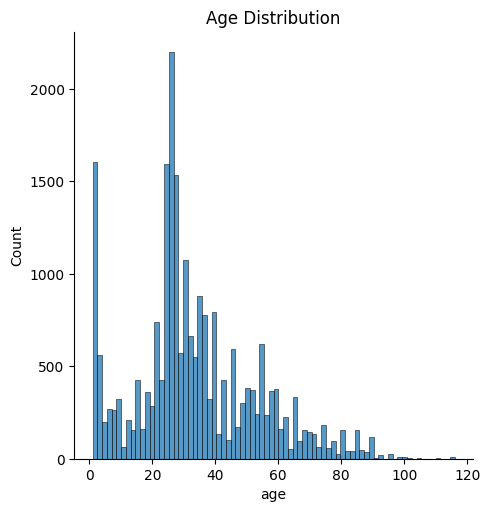

In [5]:
# Plot the age distribution
sns.displot(df['age'], kde=False)
plt.title("Age Distribution")
plt.show()

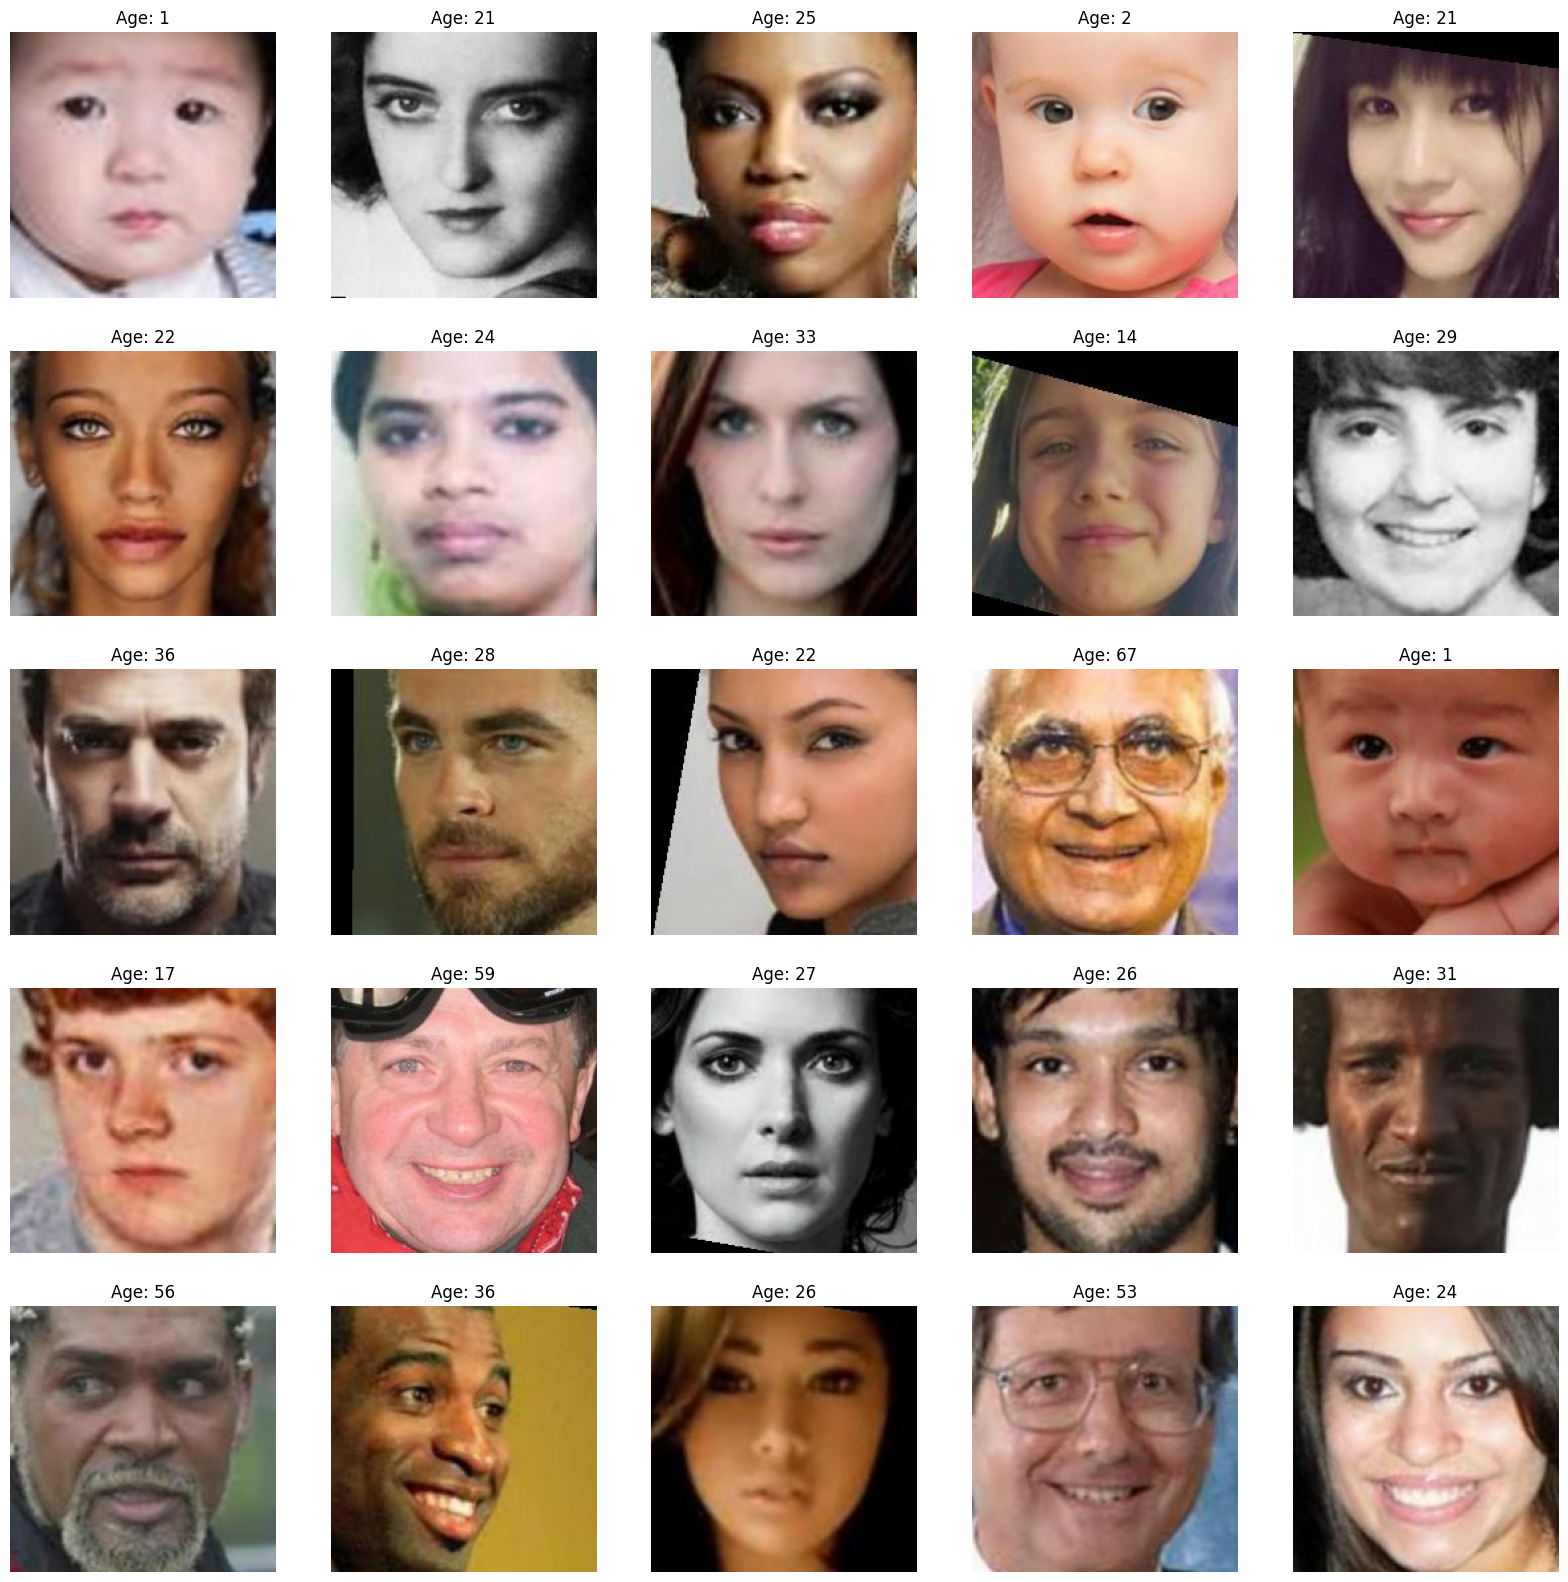

In [6]:
# Display a grid of images with labels
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

# Use plain tuples to access rows
for index, row in enumerate(files.itertuples(index=False, name=None), 1):
    plt.subplot(5, 5, index)
    
    file = row[0]
    age = row[1]
    
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age}")
    plt.axis('off')

plt.show()

### Feature Extraction

In [7]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.Resampling.LANCZOS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [8]:
X = extract_features(df['image'])
X = X / 255.0
y_age = np.array(df['age'])

100%|██████████| 23708/23708 [02:08<00:00, 185.11it/s]


In [9]:
X.shape

(23708, 128, 128, 1)

### Model Creation

In [17]:
input_shape = (128, 128, 1)
inputs = Input((input_shape))

# Define the convolutional layers for age prediction
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
batchnorm_1 = BatchNormalization()(conv_1)
maxp_1 = MaxPooling2D(pool_size=(2, 2))(batchnorm_1)
dropout_conv_1 = Dropout(0.3)(maxp_1)

conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(dropout_conv_1)
batchnorm_2 = BatchNormalization()(conv_2)
maxp_2 = MaxPooling2D(pool_size=(2, 2))(batchnorm_2)
dropout_conv_2 = Dropout(0.3)(maxp_2)

conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(dropout_conv_2)
batchnorm_3 = BatchNormalization()(conv_3)
maxp_3 = MaxPooling2D(pool_size=(2, 2))(batchnorm_3)
dropout_conv_3 = Dropout(0.3)(maxp_3)

conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(dropout_conv_3)
batchnorm_4 = BatchNormalization()(conv_4)
maxp_4 = MaxPooling2D(pool_size=(2, 2))(batchnorm_4)
dropout_conv_4 = Dropout(0.3)(maxp_4)

flatten = Flatten()(dropout_conv_4)

# Fully connected layers with L2 regularization
dense_1 = Dense(256, activation='relu', kernel_regularizer=l2(0.02))(flatten)

dropout_1 = Dropout(0.5)(dense_1)

output_2 = Dense(1, activation='softplus')(dropout_1)

model = Model(inputs=[inputs], outputs=[output_2])

model.compile(
    loss='mse',
    optimizer=Adam(learning_rate=0.00005),
    metrics=['mae']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7),
    ModelCheckpoint('../models/best_age_model.keras', monitor='val_loss', save_best_only=True)
]

In [18]:
history = model.fit(
    x=X, 
    y=y_age,
    batch_size=32, 
    epochs=100, 
    validation_split=0.2,
    callbacks=callbacks
)

Epoch 1/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 214s 356ms/step - loss: 413.1304 - mae: 15.2119 - val_loss: 557.2993 - val_mae: 18.6170 - learning_rate: 5.0000e-05
Epoch 2/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 206s 347ms/step - loss: 224.4540 - mae: 11.1383 - val_loss: 255.4070 - val_mae: 11.6325 - learning_rate: 5.0000e-05
Epoch 3/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 208s 351ms/step - loss: 193.6120 - mae: 10.1687 - val_loss: 187.8116 - val_mae: 9.9760 - learning_rate: 5.0000e-05
Epoch 4/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 208s 351ms/step - loss: 179.8335 - mae: 9.6713 - val_loss: 227.9574 - val_mae: 11.3299 - learning_rate: 5.0000e-05
Epoch 5/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 212s 358ms/step - loss: 160.5163 - mae: 9.1356 - val_loss: 197.8672 - val_mae: 10.5094 - learning_rate: 5.0000e-05
Epoch 6/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 209s 352ms/step - loss: 155.1845 - mae: 8.9885 - val_loss: 168.1152 - val_mae: 9.3229 - learning_rate: 5.0000e-05
Epoch 7/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 208s 351ms/step - loss

### Plot the results

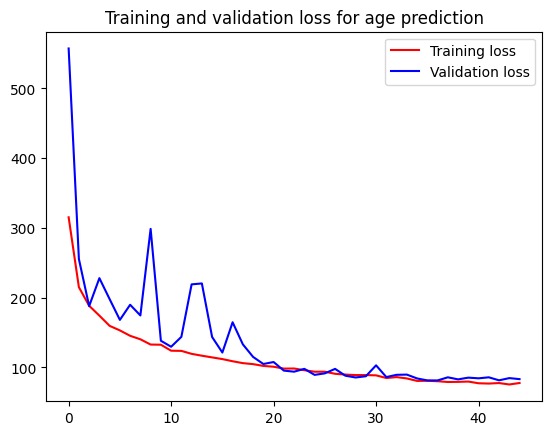

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [19]:
# plot results for age
loss = history.history.get('loss', history.history.get('loss'))
val_loss = history.history.get('val_loss', history.history.get('val_loss'))

epochs = range(len(loss))

# Plot training and validation loss
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for age prediction')
plt.legend()
plt.show()
plt.figure()

In [20]:
# Access validation MAE from the training history
val_age_mae = history.history['val_mae'][-1]
print(f"Validation Mean Absolute Error for Age Prediction: {val_age_mae:.2f}")

Validation Mean Absolute Error for Age Prediction: 6.35


### Prediction with Test Data

Original Age:  15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Predicted Age:  17


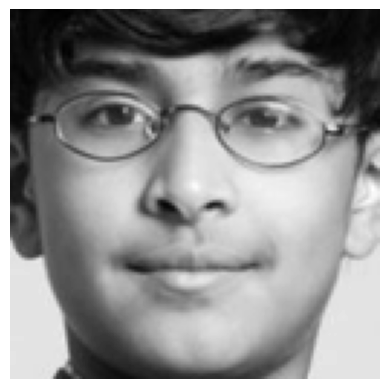

In [21]:
# Age Prediction Code
image_index = 2000
print("Original Age: ", y_age[image_index])

# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_age = round(pred[0][0])

print("Predicted Age: ", pred_age)

plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');
plt.show()